In [51]:
# IMPORTS

# add the install flags
#!pip install openpyxl
#!pip install xlrd
#!pip install xlsxwriter
#!pip install xlwt


In [1]:
# import Libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import time, datetime

# warnings
import warnings
warnings.filterwarnings('ignore')

#### Data Load

In [4]:
retail_original = pd.read_excel('/content/Online Retail.xlsx', dtype={'CustomerID': str,'InvoiceNo': str})
retail_original.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

#### Globals

In [7]:

random_state = 0
#
# countries
country_filter = []
#country_filter = ['United Kingdom'] #United Kingdom is the country that contributes the most to this dataset. May explore other countries after..
#country_filter = ['United Kingdom','Germany','France','EIRE']
#
# drop/include duplicates
drop_duplicates = 1 # set to 0 to include
#

#### Functions

In [8]:
# display null counts and % for df
def display_info(df):
    df_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
    df_info=df_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
    df_info=df_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
    display(df_info)
    display(df.sample(5, random_state=random_state))
    print(df.shape)

#### Explore

In [9]:
# gives some infos on columns types and numer of null values
display_info(retail_original)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
387967,570410,22396,MAGNETS PACK OF 4 RETRO PHOTO,1,2011-10-10 13:04:00,0.39,16776,United Kingdom
510721,579467,23560,SET OF 6 RIBBONS COUNTRY STYLE,6,2011-11-29 14:57:00,2.89,15755,United Kingdom
416072,572550,23567,EGG CUP HENRIETTA HEN PINK,1,2011-10-24 17:06:00,2.46,NaN,United Kingdom
437992,574301,20749,ASSORTED COLOUR MINI CASES,4,2011-11-03 16:15:00,7.95,12544,Spain
166468,550921,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,2011-04-21 14:21:00,0.55,14770,United Kingdom


(541909, 8)


In [10]:
# better to drop na here, its a rabbit hole to impute the null values
retail_original.dropna(inplace=True)
display_info(retail_original)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
209444,555240,20727,LUNCH BAG BLACK SKULL.,3,2011-06-01 13:07:00,1.65,15039,United Kingdom
389683,570488,21739,COSY SLIPPER SHOES SMALL GREEN,2,2011-10-10 17:12:00,2.46,14096,United Kingdom
184515,552694,22938,CUPCAKE LACE PAPER SET 6,12,2011-05-10 15:25:00,1.95,12749,United Kingdom
98089,544667,22896,PEG BAG APPLES DESIGN,50,2011-02-22 15:10:00,2.10,17511,United Kingdom
268149,560392,15034,PAPER POCKET TRAVELING FAN,96,2011-07-18 13:30:00,0.14,13911,United Kingdom


(406829, 8)


United Kingdom    19857
Germany             603
France              458
EIRE                319
Belgium             119
Spain               105
Netherlands         101
Switzerland          71
Portugal             70
Australia            69
Name: Country, dtype: int64


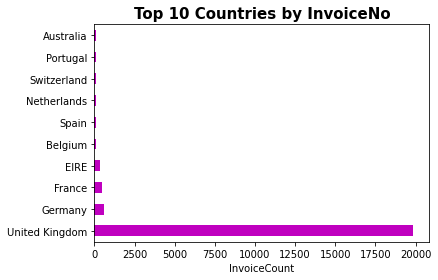

In [25]:
# Invoice counts by countries..
print(retail_original.drop_duplicates(subset=['Country','InvoiceNo']).Country.value_counts()[:10])
retail_original.drop_duplicates(subset=['Country','InvoiceNo']).Country.value_counts()[:10].plot(kind='barh', color = 'm')
plt.title("Top 10 Countries by InvoiceNo",weight = 'bold', size = 15)
plt.xlabel('InvoiceCount')
plt.show()

**FILTERS**

In [26]:
# Show selected countries
print('Countries filtered: {}'.format(country_filter))

## Apply filters
# countries
if len(country_filter) > 0:
    retail_norm = retail_original.loc[retail_original['Country'].isin(country_filter)]
else:
    retail_norm = retail_original.copy()
    
# how many duplicate values? should we drop them from a transactional system or no?
print('Possible duplicates: {}'.format(retail_norm.duplicated().sum()))

# duplicates
if drop_duplicates == 1:
    retail_norm = retail_norm.drop_duplicates()
else:
    retail_norm = retail_norm.copy()

Countries filtered: []
Possible duplicates: 5225


In [27]:
display_info(retail_norm)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
512818,579516,22326,ROUND SNACK BOXES SET OF4 WOODLAND,1,2011-11-29 17:52:00,2.95,17841,United Kingdom
266107,560244,82581,TOILET METAL SIGN,3,2011-07-17 12:14:00,0.55,16931,United Kingdom
419372,572772,23313,VINTAGE CHRISTMAS BUNTING,5,2011-10-26 10:29:00,4.95,17511,United Kingdom
387383,570287,23247,BISCUIT TIN 50'S CHRISTMAS,6,2011-10-10 11:37:00,2.89,17425,United Kingdom
506771,579154,21481,FAWN BLUE HOT WATER BOTTLE,2,2011-11-28 13:27:00,3.75,17218,United Kingdom


(401604, 8)


**Preprocessing**

#### Inspect Totals

In [30]:
# total products/transactions/customers
totals_df = pd.DataFrame([{'products': len(retail_norm['StockCode'].value_counts()),
                           'transactions': len(retail_norm['InvoiceNo'].value_counts()),
                           'customers': len(retail_norm['CustomerID'].value_counts()),}],
                         columns = ['products', 'transactions', 'customers'],
                         index = ['quantity'])

display(totals_df)

,products,transactions,customers
quantity,3684,22190,4372


In [31]:
# Products per invoice
tmp = retail_norm.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
products_per_invoice = tmp.rename(columns = {'InvoiceDate':'TotalProducts'})
products_per_invoice[:10].sort_values('TotalProducts', ascending=False)

,CustomerID,InvoiceNo,TotalProducts
7,12347,573511,47
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
6,12347,562032,22
5,12347,556201,18
9,12348,539318,17
8,12347,581180,11
0,12346,541431,1
1,12346,C541433,1


#### Flag and strip unwanted records

##### Cancelled Orders

In [32]:
# number of cancelled orders
products_per_invoice['order_cancelled'] = products_per_invoice['InvoiceNo'].apply(lambda x:int('C' in x))
display(products_per_invoice[:5])
#
n1 = products_per_invoice['order_cancelled'].sum()
n2 = products_per_invoice.shape[0]
print('Number of cancelled orders: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,TotalProducts,order_cancelled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of cancelled orders: 3654/22190 (16.47%) 


In [33]:
# validate cancelled orders (negative quantity) vs original order (positive quantity)
df_tmp = retail_norm[retail_norm['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_tmp.iterrows():
    if retail_norm[(retail_norm['CustomerID'] == col[0]) & (retail_norm['Quantity'] == -col[1]) 
                & (retail_norm['Description'] == col[2])].shape[0] == 0: 
        print(df_tmp.loc[index])
        print(7*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
-------> HYPOTHESIS NOT FULFILLED


In [34]:
# validate cancelled orders (negative quantity) vs original order (positive quantity) but ignore discounts
df_tmp = retail_norm[(retail_norm['Quantity'] < 0) & (retail_norm['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_tmp.iterrows():
    if retail_norm[(retail_norm['CustomerID'] == col[0]) & (retail_norm['Quantity'] == -col[1]) 
                & (retail_norm['Description'] == col[2])].shape[0] == 0: 
        print(index, df_tmp.loc[index])
        print(7*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
-------> HYPOTHESIS NOT FULFILLED


##### First find Mismatched Cancelled Orders

In [35]:
# first find mismatched cancelled orders, in case we drop them accidentally and can not obtain original order.
retail_clean = retail_norm.copy()
retail_clean['CancelledQuantity'] = 0
#
mismatched_cancelled_orders = []; mismatched_suspect_orders = []
#
start = time.time()
for index, row in retail_clean.iterrows():
    if ((row['Quantity'] < 0) and (row['Description'] != 'Discount') and re.match('^[a-zA-Z]+', row['InvoiceNo'])):
        df_test = retail_clean[(retail_clean['CustomerID'] == row['CustomerID']) &
                              (retail_clean['StockCode']  == row['StockCode']) & 
                              (retail_clean['InvoiceNo'] != row['InvoiceNo']) & 
                              (retail_clean['InvoiceDate'] < row['InvoiceDate']) & 
                              (retail_clean['Quantity'] > 0) &
                              (abs(retail_clean['Quantity']) == abs(row['Quantity']))].copy()

        #
        # Cancelation WITHOUT counterpart
        if (df_test.shape[0] == 0): 
            mismatched_suspect_orders.append(index)
        #
        # Cancelation WITH a counterpart
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            #retail_clean.loc[index_order, 'CancelledQuantity'] = -row['Quantity']
            mismatched_cancelled_orders.append(index)
            mismatched_cancelled_orders.append(index_order)
        #
        # Various counterparts exist in orders: we delete the last one
        elif (df_test.shape[0] > 1):
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -row['Quantity']: continue
                #retail_clean.loc[ind, 'CancelledQuantity'] = -row['Quantity']
                mismatched_cancelled_orders.append(index) 
                break
#
end = time.time()
print('Duration: {}'.format(datetime.timedelta(seconds = end-start)))
print('mismatched_suspect_orders: {}'.format(len(mismatched_suspect_orders)))
print('mismatched_cancelled_orders: {}'.format(len(mismatched_cancelled_orders)))

Duration: 0:11:30.686601
mismatched_suspect_orders: 5879
mismatched_cancelled_orders: 5192


In [36]:
# drop flagged entries
retail_clean.drop(mismatched_cancelled_orders, axis = 0, inplace = True)

# we can inspect these after to see if they exist..
#retail_clean.drop(mismatched_suspect_orders, axis = 0, inplace = True)

##### Cancelled Orders with Original Orders, and Cancelled Orders without

In [37]:
# flag cancelled orders without original order entry
# flag cancelled orders with original order entry
#
drop_entry = [] ; suspect_entry = []
#
start = time.time()
for index, col in retail_clean.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = retail_clean[(retail_clean['CustomerID'] == col['CustomerID']) &
                         (retail_clean['StockCode']  == col['StockCode']) & 
                         (retail_clean['InvoiceDate'] < col['InvoiceDate']) & 
                         (retail_clean['Quantity']   > 0)].copy()
    #
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        suspect_entry.append(index)
    #
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        retail_clean.loc[index_order, 'CancelledQuantity'] = -col['Quantity']
        drop_entry.append(index)        
    #
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            retail_clean.loc[ind, 'CancelledQuantity'] = -col['Quantity']
            drop_entry.append(index) 
            break           
#
end = time.time()
print('Duration: {}'.format(datetime.timedelta(seconds = end-start)))
print('drop_entry: {}'.format(len(drop_entry)))
print('suspect_entry: {}'.format(len(suspect_entry)))

Duration: 0:05:43.623823
drop_entry: 4591
suspect_entry: 1240


In [38]:
# drop flagged entries
retail_clean.drop(drop_entry, axis = 0, inplace = True)
retail_clean.drop(suspect_entry, axis = 0, inplace = True)

##### Possibly Missed Entries

In [39]:
# check again for cancelled entries that were possibly missed
remaining_entries = retail_clean[(retail_clean['Quantity'] < 0) & (retail_clean['StockCode'] != 'D')]
print('entries to delete: {}'.format(remaining_entries.shape[0]))

#
display(remaining_entries[:5])

# drop these entries too
retail_clean.drop(remaining_entries.index, axis = 0, inplace = True)

entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


##### Cancelled Orders that are discounts and don't belong to any other invoice

In [40]:
# cancelled entries that are discounts and don't belong to any invoice (not sure if we should drop these...)
remaining_entries = retail_clean[retail_clean['Quantity'] < 0 & retail_clean['InvoiceNo'].str.contains('^[a-zA-Z]+', regex = True)]
print('entries to delete: {}'.format(remaining_entries.shape[0]))

#
display(remaining_entries[:5])

# drop these entries too
retail_clean.drop(remaining_entries.index, axis = 0, inplace = True)

entries to delete: 77


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,0
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527,United Kingdom,0
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498,United Kingdom,0
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340,United Kingdom,0
31134,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422,United Kingdom,0


#### Check-point Inspection

##### Total Price of Purchases

In [41]:
# Calc true total price of purchase
# Add a TotalPrice column
retail_clean['TotalPrice'] = retail_clean['UnitPrice'] * (retail_clean['Quantity'] - retail_clean['CancelledQuantity'])
retail_clean.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,TotalPrice
429003,573511,22131,FOOD CONTAINER SET 3 LOVE HEART,6,2011-10-31 12:25:00,1.95,12347,Iceland,0,11.70
428957,573511,23480,MINI LIGHTS WOODLAND MUSHROOMS,12,2011-10-31 12:25:00,3.75,12347,Iceland,0,45.00
535014,581180,23508,MINI PLAYING CARDS DOLLY GIRL,20,2011-12-07 15:52:00,0.42,12347,Iceland,0,8.40
535013,581180,23506,MINI PLAYING CARDS SPACEBOY,20,2011-12-07 15:52:00,0.42,12347,Iceland,0,8.40
535012,581180,23271,CHRISTMAS TABLE SILVER CANDLE SPIKE,16,2011-12-07 15:52:00,0.83,12347,Iceland,0,13.28


**Drop Negative Entries**

In [42]:
# look for entries that are negative and drop them
print('{} Negative entries to drop.'.format(len(retail_clean[retail_clean['TotalPrice'] < 0].index)))
retail_clean.drop(retail_clean[retail_clean['TotalPrice'] < 0].index, axis = 0, inplace = True)

38 Negative entries to drop.


**Possibly Non-contributing Stock Codes**

In [43]:
# get list of stock codes
stock_code_list = retail_clean[retail_clean['StockCode'].str.contains('^[a-zA-Z]+', regex = True) == True]['StockCode'].unique()
display(stock_code_list)
#
for code in stock_code_list:
    print("{:<15} -> {:<30}".format(code, retail_clean[retail_clean['StockCode'] == code]['Description'].unique()[0]))

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

POST            -> POSTAGE                       
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


**Stock Codes with quantity < 0**

In [ ]:
# check for stock codes with quantity < 0 and if stockcode has alpha chars
# get list of stock codes
#check_stock_code_list = retail_clean[retail_clean['Quantity'] <= 0 & retail_clean['StockCode'].str.contains('^[a-zA-Z]+', regex = True)]['StockCode'].unique()
check_stock_code_list = retail_clean[retail_clean['Quantity'] <= 0]['StockCode'].unique()
display(check_stock_code_list)
#
for code in check_stock_code_list:
    print("{:<15} -> {:<30}".format(code, retail_clean[retail_clean['StockCode'] == code]['Description'].unique()[0]))

**Total Cart Price**

In [ ]:
# Purchase total by CustomerID, InvoiceNo
tmp = retail_clean.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
cart_price = tmp.rename(columns = {'TotalPrice':'Cart Price'})

# Add/Fill purchase dates
retail_clean['InvoiceDate_int'] = retail_clean['InvoiceDate'].astype('int64')
tmp = retail_clean.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
retail_clean.drop('InvoiceDate_int', axis = 1, inplace = True)
cart_price.loc[:, 'InvoiceDate'] = pd.to_datetime(tmp['InvoiceDate_int'])

# Only purchases with positive net value
cart_price = cart_price[cart_price['Cart Price'] > 0]
cart_price.sort_values('CustomerID')[:6]

**Check Total Price < 0**

In [44]:
#retail_clean[retail_clean['InvoiceNo'] == '573077']
retail_clean[retail_clean['TotalPrice'] < 0]
#retail_clean[retail_clean.index.isin(mismatched_suspect_orders)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,TotalPrice


In [47]:
display_info(retail_clean)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,TotalPrice
column type,object,object,object,int64,datetime64[ns],float64,object,object,int64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,TotalPrice
427093,573375,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-10-30 13:42:00,4.15,15521,United Kingdom,0,16.60
502941,578854,22411,JUMBO SHOPPER VINTAGE RED PAISLEY,10,2011-11-27 11:15:00,2.08,14859,United Kingdom,0,20.80
328481,565779,22727,ALARM CLOCK BAKELIKE RED,4,2011-09-06 15:14:00,3.75,15804,United Kingdom,0,15.00
131738,547623,22979,PANTRY WASHING UP BRUSH,12,2011-03-24 11:29:00,1.45,15641,United Kingdom,0,17.40
229729,557109,21137,BLACK RECORD COVER FRAME,72,2011-06-16 16:06:00,3.39,15694,United Kingdom,0,244.08


(390453, 10)


##### Save

In [52]:
writer = pd.ExcelWriter('online_retail_normalized.xlsx', engine='xlsxwriter')
retail_clean.to_excel(writer, sheet_name='Sheet1', index = False)
writer.save()